# MCMC

*10 Mar 2020*

Arthur Tsang

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

## Rotation curve

In [47]:
from functions import diskhalo_fit, expdisk_fit, uniform_fit, bulgedisk_fit

In [48]:
data = np.loadtxt('mcmc_files/rotcurve_data.txt')

In [49]:
radius_list, vel_list, vel_err_list = data[:,0], data[:,1], data[:,2]

In [95]:
def log_prob(x):
    #if np.any(x < 0): return -np.inf
    
    #rd, sig0 = x
    vfit_list = [bulgedisk_fit(r, *x) for r in radius_list]
    #plt.plot(radius_list, vfit_list)
    #plt.plot(radius_list, vel_list)
    #print(vfit_list)
#     print(vfit_list[0], vel_list[0])
    lprob = sum(-(vf-v)**2/(2*ve**2) for v, vf, ve in zip(vel_list, vfit_list, vel_err_list))
    #lprob = sum(-(vf-v)**2 for vf, v in zip(vfit_list, vel_list))
    #print(lprob)
    #lprob += sum(np.log(1/np.sqrt(2*np.pi)/ve) for ve in vel_err_list)
    #print(x, lprob)
    if lprob != lprob:
        #print('nan!, x=',x)
        return -np.inf
    return lprob

In [96]:
ndim = 4
nwalkers = 2*ndim

In [97]:
popt_cheat = [2.95445014e-07, 1.64347024e+10, 3.41357439e+00, 6.26878647e+06] # bulgedisk

In [98]:
p0 = np.array([popt_cheat for _ in range(nwalkers)]) + 0.01 * np.random.randn(nwalkers, ndim) #[3,1e7, 5, 1e7]

In [99]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
state = sampler.run_mcmc(p0, 1500)

dim 0


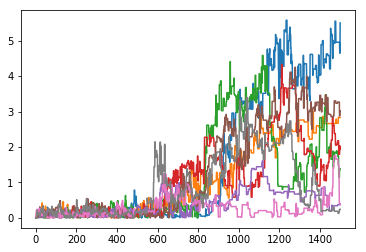

dim 1


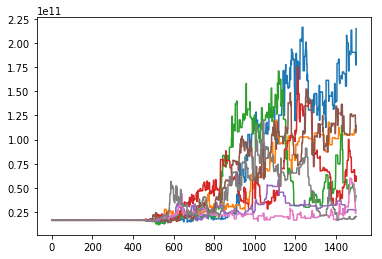

dim 2


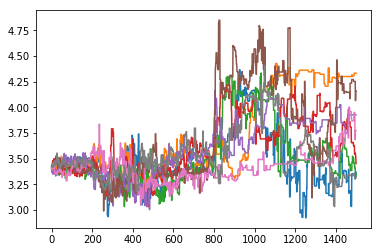

dim 3


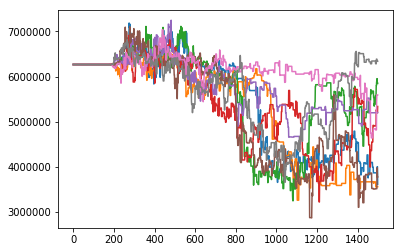

In [100]:
chain = sampler.get_chain()
for dim in range(ndim):
    print('dim', dim)
    for walker in range(nwalkers):
        plt.plot(abs(chain[:,walker,dim]))
    plt.show()

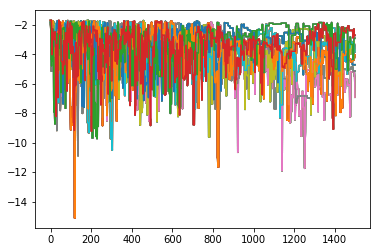

In [101]:
for walker in range(nwalkers):
    plt.plot(sampler.get_log_prob())
#plt.ylim(-100,0)

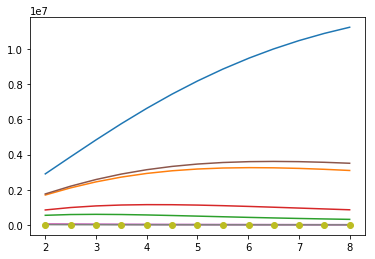

(0, 100000.0)

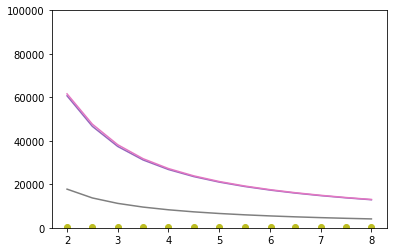

In [104]:
chain = sampler.get_chain()
for walker in range(nwalkers):
    x = chain[-1,walker,:]
    plt.plot(radius_list, [diskhalo_fit(r, *x) for r in radius_list])
plt.errorbar(radius_list, vel_list, vel_err_list, fmt='o')
plt.show()

for walker in range(nwalkers):
    x = chain[-1,walker,:]
    plt.plot(radius_list, [diskhalo_fit(r, *x) for r in radius_list])
plt.errorbar(radius_list, vel_list, vel_err_list, fmt='o')
plt.ylim(0,1e5)

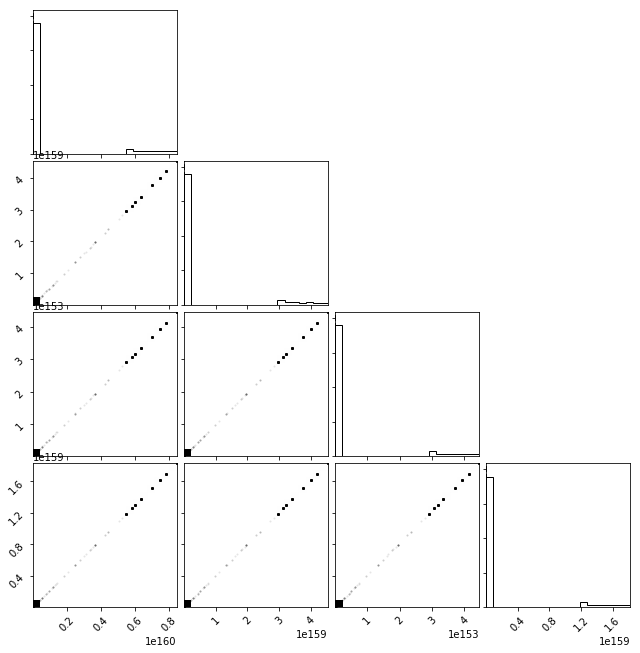

In [94]:
burnin = 400
x_chain = chain[400:].reshape(-1,ndim)

corner.corner(abs(x_chain), 
              #labels=['rd', 'sig0', 'rh', 'rhoh'],
              quantiles=[0.16, 0.5, 0.84],
              show_titles=False)
plt.show()

## Disk width (single gaussian)

In [2]:
from functions import single_gaussian

In [3]:
data = np.loadtxt('mcmc_files/diskwidth_data.npy')
b_list, w_list, w_err_list = data[:,0], data[:,1], data[:,2]

In [6]:
def log_prob(x):
    w_fit_list = [single_gaussian(b, *x) for b in b_list]
    lprob = sum(-(wf-w)**2/(2*we**2) for w,wf,we in zip(w_list, w_fit_list, w_err_list))
    lprob += sum(np.log(1/np.sqrt(2*np.pi*sig**2)) for sig in w_err_list)
    return lprob

In [7]:
ndim = 3
nwalkers = 2 * ndim

In [8]:
popt_cheat = [-0.07096154,  0.27820271, 42.62602721]
p0 = np.array([popt_cheat for _ in range(nwalkers)]) + 0.01 * np.random.randn(nwalkers, ndim)

In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
state = sampler.run_mcmc(p0, 5000)
chain = sampler.get_chain()

dim 0


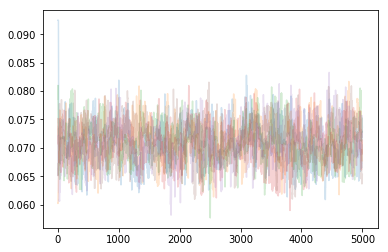

dim 1


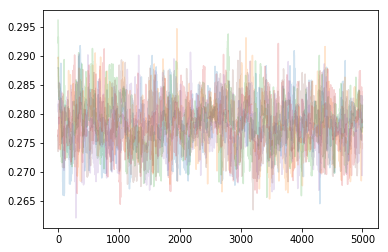

dim 2


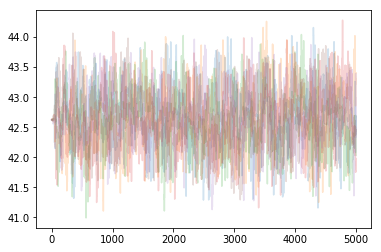

In [11]:
for dim in range(ndim):
    print('dim', dim)
    for walker in range(nwalkers):
        plt.plot(abs(chain[:,walker,dim]), alpha=.2)
    plt.show()

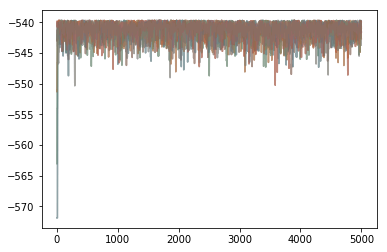

In [12]:
for walker in range(nwalkers):
    plt.plot(sampler.get_log_prob(), alpha=.2)

In [36]:
burnin = 400
param_means = np.mean(chain[burnin:,:,:].reshape(-1,ndim), axis=0)
param_stds = np.std(chain[burnin:,:,:].reshape(-1,ndim), axis=0, ddof=1)

In [39]:
param_stds

array([0.0032624 , 0.00397215, 0.46654636])

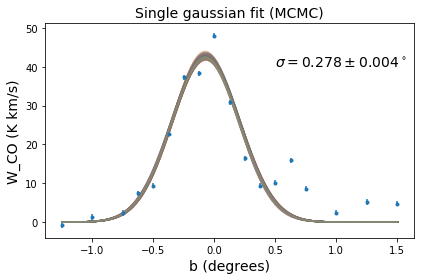

In [45]:
b_all = np.linspace(-1.25, 1.5, 100)
burnin = -30
x_chain = chain[burnin:,:,:].reshape(-1,ndim)
for instance in x_chain:
    plt.plot(b_all, [single_gaussian(b, *instance) for b in b_all], alpha=.2)
plt.errorbar(b_list, w_list, w_err_list, fmt='.')
plt.xlabel('b (degrees)', fontsize=14)
plt.ylabel('W_CO (K km/s)', fontsize=14)
plt.title('Single gaussian fit (MCMC)', fontsize=14)
plt.tight_layout()
plt.text(.5,40,r'$\sigma = %.3f \pm %.3f ^\circ$' % (param_means[1], param_stds[1]), size=14)
#plt.savefig('imgs/single_gaussian.png')

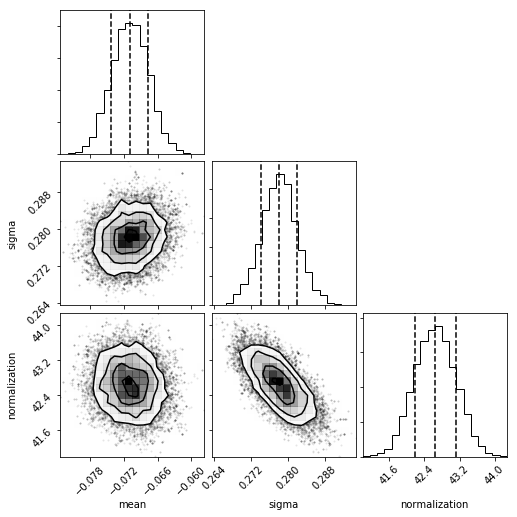

In [47]:
burnin = 400
x_chain = chain[burnin:].reshape(-1,ndim)

corner.corner(x_chain, 
              labels=['mean', 'sigma', 'normalization'],
              quantiles=[0.16, 0.5, 0.84],
              show_titles=False)
#plt.savefig('imgs/single_gaussian_corner.png')

In [21]:
print(np.mean(x_chain, axis=0), np.std(x_chain, axis=0, ddof=1))

[-0.07092401  0.27810849 42.64207762] [0.0032624  0.00397215 0.46654636]


## Disk width (double gaussian)

In [48]:
from functions import double_gaussian

In [49]:
data = np.loadtxt('mcmc_files/diskwidth_data.npy')
b_list, w_list, w_err_list = data[:,0], data[:,1], data[:,2]

In [50]:
def log_prob(x):
    w_fit_list = [double_gaussian(b, *x) for b in b_list]
    lprob = sum(-(wf-w)**2/(2*we**2) for w,wf,we in zip(w_list, w_fit_list, w_err_list))
    lprob += sum(np.log(1/np.sqrt(2*np.pi*sig**2)) for sig in w_err_list)
    return lprob

In [51]:
ndim = 6
nwalkers = 2*ndim

In [52]:
popt_cheat = [-0.09681686,  0.20888485, 37.56430858,  0.38489606,  0.73162962, 9.76525117]

In [53]:
p0 = np.array([popt_cheat for _ in range(nwalkers)]) + 0.01 * np.random.randn(nwalkers, ndim) #[3,1e7, 5, 1e7]

In [54]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
state = sampler.run_mcmc(p0, 5000)

dim 0


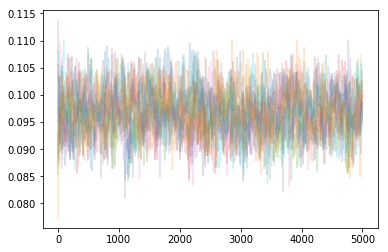

dim 1


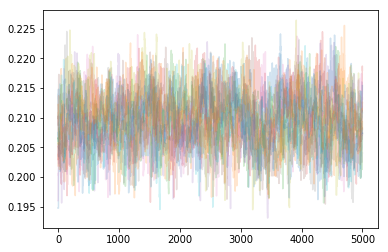

dim 2


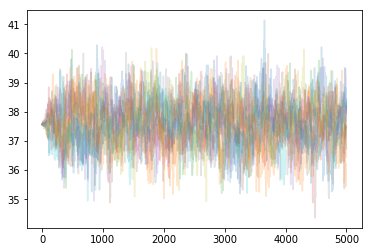

dim 3


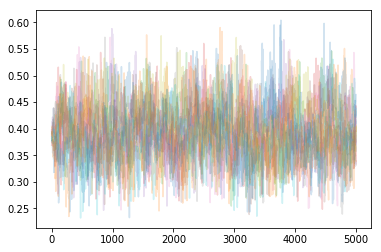

dim 4


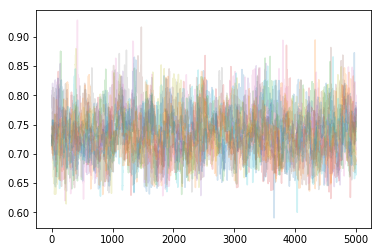

dim 5


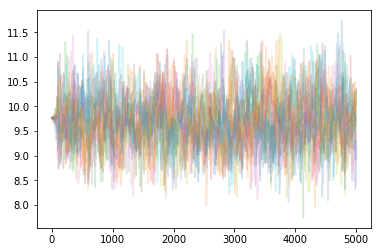

In [55]:
chain = sampler.get_chain()
for dim in range(ndim):
    print('dim', dim)
    for walker in range(nwalkers):
        plt.plot(abs(chain[:,walker,dim]), alpha=.2)
    plt.show()

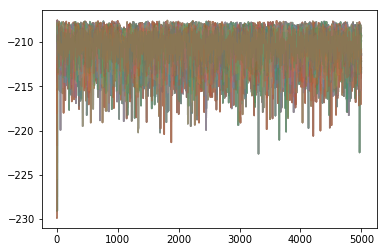

In [56]:
for walker in range(nwalkers):
    plt.plot(sampler.get_log_prob(), alpha=.2)

In [58]:
burnin = 400
param_means = np.mean(chain[burnin:,:,:].reshape(-1,ndim), axis=0)
param_stds = np.std(chain[burnin:,:,:].reshape(-1,ndim), axis=0, ddof=1)

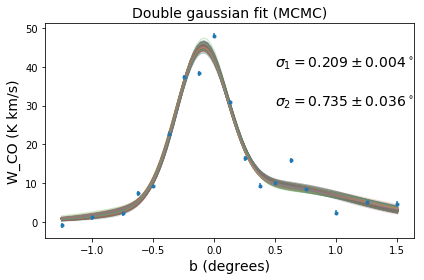

In [62]:
b_all = np.linspace(-1.25, 1.5, 100)
burnin = -30
x_chain = chain[burnin:,:,:].reshape(-1,ndim)
for instance in x_chain:
    plt.plot(b_all, [double_gaussian(b, *instance) for b in b_all], alpha=.2)
plt.errorbar(b_list, w_list, w_err_list, fmt='.')
plt.xlabel('b (degrees)', fontsize=14)
plt.ylabel('W_CO (K km/s)', fontsize=14)
plt.title('Double gaussian fit (MCMC)', fontsize=14)
plt.tight_layout()
plt.text(.5,40,r'$\sigma_1 = %.3f \pm %.3f ^\circ$' % (param_means[1], param_stds[1]), size=14)
plt.text(.5,30,r'$\sigma_2 = %.3f \pm %.3f ^\circ$' % (param_means[4], param_stds[4]), size=14)
#plt.savefig('imgs/double_gaussian.png')

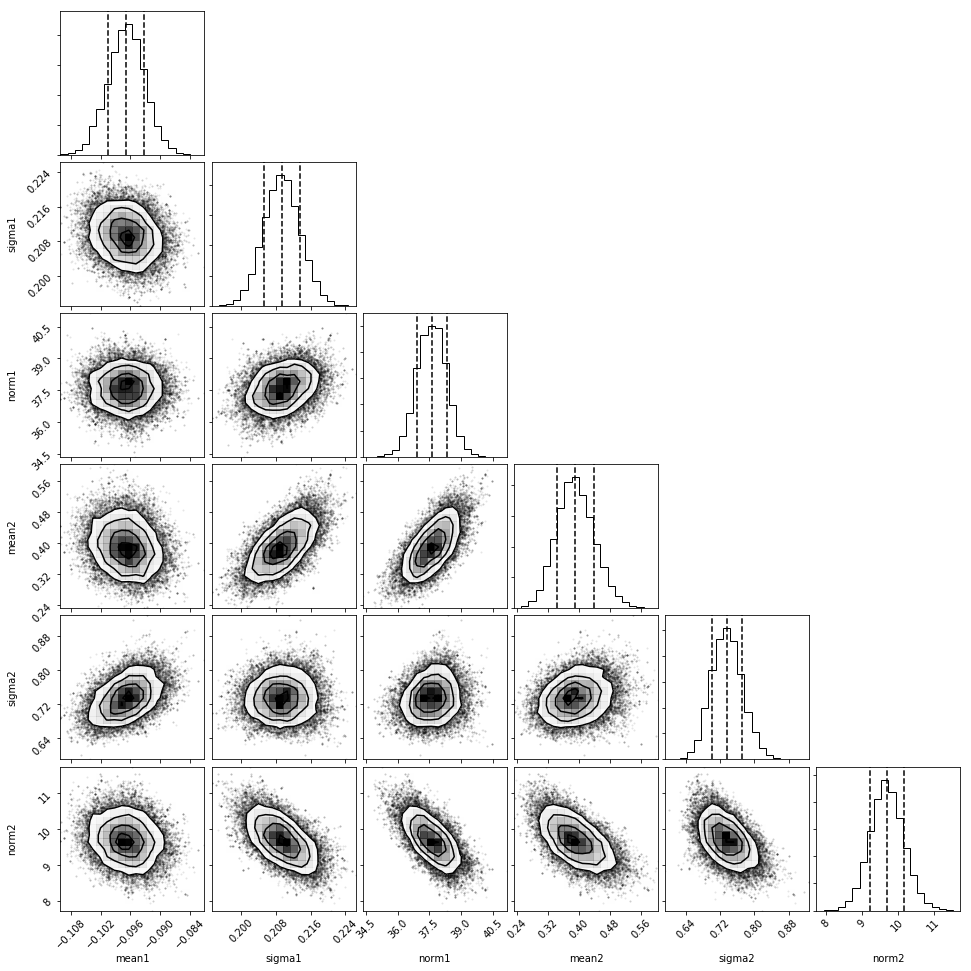

In [66]:
burnin = 400
x_chain = chain[burnin:].reshape(-1,ndim)

corner.corner(x_chain, 
              labels=['mean1', 'sigma1', 'norm1', 'mean2', 'sigma2', 'norm2'],
              quantiles=[0.16, 0.5, 0.84],
              show_titles=False)
#plt.savefig('imgs/double_gaussian_corner.png')
plt.show()

In [15]:
chain = sampler.get_chain()
width0 = np.mean(chain[burnin:,:,1])
width1 = np.mean(chain[burnin:,:,4])
width0, width1

(0.2094586476998572, 0.7325104740706777)

In [16]:
norm0 = np.mean(chain[burnin:,:,2])
norm1 = np.mean(chain[burnin:,:,5])

In [17]:
norm0

37.601206030605155

In [18]:
norm1

9.754697474709262

In [19]:
avg_sigma = (width0 * norm0 + width1 * norm1)/(norm0+norm1)

In [20]:
avg_sigma

0.3172004908951607

In [22]:
width_deg = np.sqrt(2*np.pi)*avg_sigma

In [24]:
rsun = 8.34 # kpc

In [25]:
(width_deg * np.pi/180)*rsun*np.cos(32.65*np.pi/180)

0.097447334437107